# **Lunar Lander con Q-Learning**

# **1. Bibliotecas**

In [1]:
!pip3 install cmake gymnasium scipy numpy gymnasium[box2d] pygame==2.6.0 swig
import sys
# Tal vez tengan que ejecutar lo siguiente en sus máquinas (ubuntu 20.04)
# sudo apt-get remove swig
# sudo apt-get install swig3.0
# sudo ln -s /usr/bin/swig3.0 /usr/bin/swig
# En windows tambien puede ser necesario MSVC++
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

zsh:1: no matches found: gymnasium[box2d]


# **2. Jugando a mano**

A continuación se puede jugar un episodio del lunar lander. Se controlan los motores con el teclado. Notar que solo se puede realizar una acción a la vez (que es parte del problema), y que en esta implementación, izq toma precedencia sobre derecha, que toma precedencia sobre el motor principal.

In [32]:
# Nota: hay que transformar esta celda en código para ejecutar (Esc + y)

import pygame
from pygame.locals import *

# Inicializar pygame (para el control con el teclado) y el ambiente
pygame.init()
env = gym.make('LunarLander-v2', render_mode='human')
env.reset()
pygame.display.set_caption('Lunar Lander')

clock = pygame.time.Clock()
done = False

while not done:
    for event in pygame.event.get():
        if event.type == QUIT:
            done = True
            break

    keys = pygame.key.get_pressed()

    # Map keys to actions
    if keys[K_LEFT]:
        action = 3  # Fire left orientation engine
    elif keys[K_RIGHT]:
        action = 1 # Fire right orientation engine
    elif keys[K_UP]:
        action = 2  # Fire main engine
    else:
        action = 0  # Do nothing

    _, _, terminated, truncated, _ = env.step(action)
    env.render()
    clock.tick(10)

    if terminated or truncated:
        done = True

env.close()
pygame.quit()

# **3. Discretizando el estado**

El estado consiste de posiciones y velocidades en (x,y,theta) y en información de contacto de los pies con la superficie.

Como varios de estos son continuos, tenemos que discretizarlos para aplicar nuestro algoritmo de aprendizaje por refuerzo tabular.

In [73]:
# Cuántos bins queremos por dimensión
# Pueden considerar variar este parámetro
bins_per_dim = 15

# Estado:
# (x, y, x_vel, y_vel, theta, theta_vel, pie_izq_en_contacto, pie_derecho_en_contacto)
NUM_BINS = [bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, bins_per_dim, 2, 2]

env = gym.make('LunarLander-v2')
env.reset()

# Tomamos los rangos del env
OBS_SPACE_HIGH = env.observation_space.high
OBS_SPACE_LOW = env.observation_space.low
OBS_SPACE_LOW[1] = 0 # Para la coordenada y (altura), no podemos ir más abajo que la zona dea aterrizae (que está en el 0, 0)

# Los bins para cada dimensión
bins = [
    np.linspace(OBS_SPACE_LOW[i], OBS_SPACE_HIGH[i], NUM_BINS[i] - 1)
    for i in range(len(NUM_BINS) - 2) # last two are binary
]
# Se recomienda observar los bins para entender su estructura
# print ("Bins: ", bins)

# **4. Agentes y la interacción con el entorno**

Vamos a definir una interfaz para nuestro agente:

In [3]:
class Agente:
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó
        """
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Aprender a partir de la tupla
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
            - terminado: si el episodio terminó en esta transición
        """
        pass

    def fin_episodio(self):
        """Actualizar estructuras al final de un episodio"""
        pass

Para un agente aleatorio, la implementación sería:

In [4]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion, explorar = True) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        # No aprende
        pass

    def fin_episodio(self):
        # Nada que actualizar
        pass

Luego podemos definir una función para ejecutar un episodio con un agente dado:

In [4]:
def ejecutar_episodio(agente, aprender = True, render = None, max_iteraciones=500):
    entorno = gym.make('LunarLander-v2', render_mode=render).env

    iteraciones = 0
    recompensa_total = 0

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset()
    while iteraciones < max_iteraciones and not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n, aprender)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        if (aprender):
            agente.aprender(estado_anterior, estado_siguiente, accion, recompensa, termino)

        estado_anterior = estado_siguiente
        iteraciones += 1
        recompensa_total += recompensa
    if (aprender):
        agente.fin_episodio()
    entorno.close()
    return recompensa_total

Podemos ejecutar este ambiente muchas veces y tomar métricas al respecto

In [6]:
agente = AgenteAleatorio()
recompensa_episodios = []

exitos = 0
num_episodios = 100
for i in range(num_episodios):
    recompensa = ejecutar_episodio(agente)
    # Los episodios se consideran exitosos si se obutvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos += 1
    recompensa_episodios += [recompensa]

import numpy
print(f"Tasa de éxito: {exitos / num_episodios}. Se obtuvo {numpy.mean(recompensa_episodios)} de recompensa, en promedio")

Tasa de éxito: 0.0. Se obtuvo -184.0164098406959 de recompensa, en promedio


# **5. Programando un agente que aprende**

## 5.1 Descripción del Agente de Aprendizaje por Refuerzo
#### 5.1.1 Selección de Acción (elegir_accion)
El agente selecciona una acción usando una política epsilon-greedy, que mezcla exploración y explotación:
* **Exploración**: Con probabilidad epsilon, el agente elige una acción aleatoria, lo que le permite explorar el espacio de acciones.
* **Explotación**: Si no se explora, el agente selecciona la acción con el valor Q más alto en el estado actual. Si el estado actual no está en la tabla Q, se inicializa con valores de acción igual a cero.

#### 5.1.2 Aprendizaje (aprender)
Durante el aprendizaje el agente actualiza su tabla Q utilizando la siguiente fórmula:
$$ \hat{Q}(s,a) \leftarrow (1-\alpha_{n})\hat{Q}(s,a) + \alpha_{n}[r(s,a) + \gamma max_{a_{2}}\hat{Q}(\delta(s,a),a_{2})] $$
En esta formula el término $ (1-\alpha_{n})\hat{Q}(s,a) $ pondera el valor actual de $ \hat{Q}(s,a) $, lo que significa que le da un peso de $ (1-\alpha_{n}) $ a la estimación previa en el proceso de evaluación. Por otro lado, $\alpha_{n}$ pondera la nueva información que se obtiene de la recompensa inmediata $ r(s,a) $ y de la estimación de la máxima recompensa futura (es decir, $ \gamma max_{a_{2}}\hat{Q}(\delta(s,a),a_{2}) $). La combinación de estos dos términos permite que la estimación de Q se actualice de manera segura y de manera balanceada entre lo que ya conocía y la nueva información que ha recibido.

Esta tasa de aprendizaje $\alpha_{n}$ controla cuánta importancia le damos a la nueva información en relación con la estimación previa, y para su valor se tomó un valor fijo que diera buenos resultados en la experimentación.

#### 5.1.3 Fin de Episodio (fin_episodio)
Al finalizar cada episodio, el valor de epsilon se reduce multiplicándose por el factor de decaimiento (*epsilon_decay*). Esto reduce gradualmente la cantidad de exploración y permite que el agente se enfoque más en la explotación de su política óptima.

### 5.2 Descripción del Agente de Aprendizaje por Refuerzo
Para entrenar al agente, ejecutamos 50000 episodios utilizando la fórmula estándar de Q-learning. Luego, para evaluar el rendimiento, ejecutamos otros 1000 episodios de explotación, midiendo la tasa de éxito, donde se considera exitoso un episodio si la recompensa total es mayor o igual a 200.

Durante la fase de aprendizaje, implementamos la política epsilon-greedy. Esta política consiste en explorar el entorno tomando una acción aleatoria con una probabilidad epsilon, mientras que el resto del tiempo se selecciona la mejor acción conocida. Al inicio del entrenamiento, el agente no tiene suficiente información sobre los resultados de las posibles acciones, por lo que es necesario realizar una exploración adecuada. A medida que el agente aprende, la probabilidad de exploración epsilon se va reduciendo mediante un factor de decaimiento llamado *epsilon_decay*, hasta alcanzar un valor mínimo *epsilon_min*. Esto permite que el agente explore al principio, pero luego se enfoque en explotar las acciones que llevan a mejores recompensas.

Durante la fase de explotación, ya no aplicamos la política epsilon-greedy dado que estamos interesados en medir el rendimiento del agente explotando únicamente las acciones que ha aprendido. Aplicar esta técnica de exploración durante la fase de explotación creemos que afectaría positivamente al agente.

## 5.2 Análisis de los parámetros utilizados en el algoritmo

Se experimentó con iteraciones cortas, alrededor de 3000 episodios, para ajustar y elegir los valores de los parámetros que optimizan el rendimiento del agente.

- ### **epsilon, epsilon_decay y epsilon_min**


	#### epsilon_min en 3000 episodios

	| `epsilon_min` | Tasa de éxito (Aprendiendo) | Recompensa promedio (Aprendiendo) | Tasa de éxito (Explotando) | Recompensa promedio (Explotando) |
	|---------------|----------------------------|-----------------------------------|----------------------------|----------------------------------|
	| 0.001         | 0.014                      | -95.19                            | 0.058                      | -43.75                           |
	| 0.01          | 0.010                      | -97.30                            | 0.035                      | -67.26                           |
	| 0.10          | 0.009                      | -96.70                            | 0.049                      | -96.76                           |

	#### epsilon_min en 5000 episodios

	| `epsilon_min` | Tasa de éxito (Aprendiendo) | Recompensa promedio (Aprendiendo) | Tasa de éxito (Explotando) | Recompensa promedio (Explotando) |
	|---------------|----------------------------|-----------------------------------|----------------------------|----------------------------------|
	| 0.001         | 0.029                      | -64.17                            | 0.074                      | 1.28                             |
	| 0.01          | 0.040                      | -64.80                            | 0.137                      | -0.78                            |
	| 0.10          | 0.018                      | -74.43                            | 0.056                      | -61.45                           |

	`epsilon_min = 0.01`: Se eligió un epsilon_min bajo para mantener una pequeña tasa de exploración en las etapas finales. Al obtener resultados similares con 3000 episodios se hizo la misma prueba con 5000 donde se consiguió una mayor tasa para 0.01.

	#### epsilon_decay en 3000 episodios

	| `epsilon_decay` | Tasa de éxito (Aprendiendo) | Recompensa promedio (Aprendiendo) | Tasa de éxito (Explotando) | Recompensa promedio (Explotando) |
	|-----------------|----------------------------|-----------------------------------|----------------------------|----------------------------------|
	| 0.9             | 0.023                      | -73.90                            | 0.069                      | -49.43                           |
	| 0.99            | 0.037                      | -67.84                            | 0.074                      | -32.84                           |
	| 0.999           | 0.013                      | -101.69                           | 0.093                      | -39.72                           |
	| 0.9999          | 0.0                        | -154.63                           | 0.001                      | -116.97                          |

	`epsilon_decay = 0.999`: Este valor de decaimiento lento se seleccionó para permitir una exploración prolongada. Se probaron tasas más rápidas (como 0.9 y 0.99) y se observó que no ofrecían suficiente tiempo para explorar antes de estabilizarse en la explotación, con 0.9999 no se obtuvieron éxitos por lo se descartó un valor tan alto. 0.999 proporcionó un equilibrio, resultando en una tasa de éxito en explotación aceptable.

	`epsilon` controla el equilibrio entre la exploración y la explotación. Inicialmente, `epsilon = 1.0`, lo que implica que el agente explora completamente el entorno realizando acciones aleatorias. A medida que avanzan los episodios, epsilon disminuye en un factor de `epsilon_decay`, hasta alcanzar el valor mínimo `epsilon_min = 0.01` (lo que significa que el 1% de las veces el agente seguirá explorando de forma aleatoria).

	Por lo que hay mayor exploración al principio, permitiendo que el agente aprenda sobre el entorno. Conforme disminuye epsilon, el agente comienza a confiar más en el conocimiento almacenado en su tabla Q. Un epsilon_min bajo en los episodios finales implica que el agente casi siempre elegirá la mejor acción basada en su conocimiento actual. Esto favorece la optimización de su política, aunque si la fase de exploración termina demasiado pronto, existe el riesgo de que el agente quede atrapado en una política subóptima.

	A medida que el valor de epsilon disminuye, se observa un incremento en la recompensa promedio y en la tasa de éxito.

- ### **gamma**


	#### gamma en 3000 episodios

	| `gamma` | Tasa de éxito (Aprendiendo) | Recompensa promedio (Aprendiendo) | Tasa de éxito (Explotando) | Recompensa promedio (Explotando) |
	|---------|------------------------------|-----------------------------------|----------------------------|----------------------------------|
	| 0.99    | 0.011                        | -94.32                            | 0.068                      | -56.39                           |
	| 0.95    | 0.0163                       | -94.91                            | 0.039                      | -109.76                          |
	| 0.90    | 0.0127                       | -102.33                           | 0.038                      | -70.30                           |
	| 0.80    | 0.0083                       | -119.56                           | 0.019                      | -114.01                          |


	Con `gamma = 0.99`, el agente valora considerablemente las recompensas a largo plazo, casi tanto como las recompensas inmediatas. Un valor cercano a 1 indica que el agente está aprendiendo políticas que no solo son efectivas a corto plazo, sino que también resultan en secuencias de acciones más largas y beneficiosas.

	Este valor es adecuado para el entorno de Lunar Lander, donde las acciones deben ser planeadas cuidadosamente, y las recompensas importantes pueden estar separadas por varios pasos. Si gamma fuera más bajo, el agente podría priorizar en exceso las recompensas inmediatas, fallando en aprender políticas que conduzcan a aterrizajes exitosos.

- ### **alpha**

	### alpha en 3000 episodios

	| `alpha` | Tasa de éxito (Aprendiendo) | Recompensa promedio (Aprendiendo) | Tasa de éxito (Explotando) | Recompensa promedio (Explotando) |
	|---------|---------------------------|---------------------------------|--------------------------|--------------------------------|
	| 0.5     | 0.004                     | -114.67                         | 0.014                    | -118.49                        |
	| 0.2     | 0.00433                   | -91.81                          | 0.025                    | -67.90                         |
	| 0.1     | 0.015                     | -97.16                          | 0.043                    | -68.42                         |
	| 0.01    | 0.005                     | -131.38                         | 0.012                    | -194.13                        |

	La tasa de aprendizaje, alpha, controla cuánto se actualizan los valores de la tabla Q en cada iteración. Con `alpha = 0.1`, el agente actualiza su conocimiento de manera gradual. Un valor de alpha más alto podría acelerar el proceso de aprendizaje, pero también podría reducir la estabilidad, ya que el agente reaccionaría de forma exagerada a nuevas experiencias. Se probaron varios valores, desde 0.5 hasta 0.01, para observar cómo afectaban la estabilidad y velocidad de aprendizaje. 0.1 resultó ser el punto óptimo, ya que valores más altos causaron inestabilidad y valores más bajos llevaron a un aprendizaje lento.

- ### **bins_per_dim**

	Un mayor número de divisiones (bins) por dimensión permite al agente aprender políticas más precisas, pero también incrementa el tamaño de la tabla Q, lo que ralentiza el proceso de aprendizaje. Al reducir el número de bins de 20 a 15, se encontró un equilibrio adecuado entre precisión y eficiencia en el aprendizaje.

In [74]:
class AgenteRL(Agente):
    def __init__(self, bins, max_accion, gamma=0.99, alpha=0.1, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.999) -> None:
        super().__init__()
        self.gamma = gamma
        self.epsilon = epsilon  # Factor de exploración
        self.epsilon_min = epsilon_min  # Mínimo valor de epsilon para la política epsilon-greedy
        self.epsilon_decay = epsilon_decay  # Decaimiento de epsilon para disminuir exploración
        self.bins = bins
        self.max_accion = max_accion
        self.q_table = {}  # Tabla Q para almacenar los valores Q de los estados y acciones
        self.alpha = alpha  # Factor de aprendizaje

    def _discretize_state(self, state):
        """Discretiza el estado continuo en una tupla de indices discretos"""

        state_disc = list()
        for i in range(len(state)):
            if i >= len(self.bins):
                state_disc.append(int(state[i]))
            else:
                state_disc.append(np.digitize(state[i], self.bins[i]))
        return tuple(state_disc)

    def elegir_accion(self, estado, max_accion, explorar=True) -> int:
        """Elige una acción usando la política epsilon-greedy."""

        estado = self._discretize_state(estado)

        if explorar and np.random.rand() < self.epsilon:  # Política epsilon-greedy
            return random.randint(0, max_accion - 1)  # Acción aleatoria
        else:
            if estado not in self.q_table:
                self.q_table[estado] = np.zeros(max_accion)  # Inicializa con ceros si no existe
            return np.argmax(self.q_table[estado])  # Acción óptima

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa, terminado):
        """Actualiza la tabla Q usando la fórmula de Q-learning."""

        estado_anterior = self._discretize_state(estado_anterior)
        estado_siguiente = self._discretize_state(estado_siguiente)
        if estado_anterior not in self.q_table:
            self.q_table[estado_anterior] = np.zeros(self.max_accion)  # Inicializa con ceros si no existe
        if estado_siguiente not in self.q_table:
            self.q_table[estado_siguiente] = np.zeros(self.max_accion)  # Inicializa con ceros si no existe

        max_q_siguiente = np.max(self.q_table[estado_siguiente]) if estado_siguiente in self.q_table else 0

        q_valor_actual = self.q_table[estado_anterior][accion]
        self.q_table[estado_anterior][accion] = (1 - self.alpha) * q_valor_actual + self.alpha * (recompensa + self.gamma * max_q_siguiente * (1 - terminado))

    def fin_episodio(self):
        """Reduce epsilon para disminuir la exploración en episodios futuros."""

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


Aprendizaje y explotación de AgenteRL:

In [75]:
agente = AgenteRL(bins, env.action_space.n)

exitos_aprendiendo = 0
num_episodios_aprendiendo = 50000
recompensa_episodios_aprendiendo = []

for i in range(num_episodios_aprendiendo):
    recompensa = ejecutar_episodio(agente, aprender = True)

    # Los episodios se consideran exitosos si se obtuvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos_aprendiendo += 1

    recompensa_episodios_aprendiendo += [recompensa]

print(f"Tasa de éxito APRENDIENDO: {exitos_aprendiendo / num_episodios_aprendiendo}. Se obtuvo {np.mean(recompensa_episodios_aprendiendo)} de recompensa, en promedio")

exitos_explotando = 0
num_episodios_explotando = 1000
recompensa_episodios_explotando = []

for i in range(num_episodios_explotando):
    recompensa = ejecutar_episodio(agente, aprender = False)

    # Los episodios se consideran exitosos si se obtuvo 200 o más de recompensa total
    if (recompensa >= 200):
        exitos_explotando += 1

    recompensa_episodios_explotando += [recompensa]

print(f"Tasa de éxito EXPLOTANDO: {exitos_explotando / num_episodios_explotando}. Se obtuvo {np.mean(recompensa_episodios_explotando)} de recompensa, en promedio")


Tasa de éxito APRENDIENDO: 0.23822. Se obtuvo 48.917178080295855 de recompensa, en promedio
Tasa de éxito EXPLOTANDO: 0.272. Se obtuvo 70.79403548666474 de recompensa, en promedio


# **6. Resultados y Análisis**

Dados los parámetros:
 - gamma=0.99
 - alpha=0.1
 - epsilon=1.0
 - epsilon_min=0.01
 - epsilon_decay=0.999
 - bins_per_dim=15
 - max_iteraciones=500
 - num_episodios_aprendiendo=500000
 - num_episodios_explotando=1000

Tasa de éxito APRENDIENDO: 0.23822. Se obtuvo 48.917178080295855 de recompensa, en promedio

Tasa de éxito EXPLOTANDO: 0.272. Se obtuvo 70.79403548666474 de recompensa, en promedio


### Graficar recompensas para ambas fases

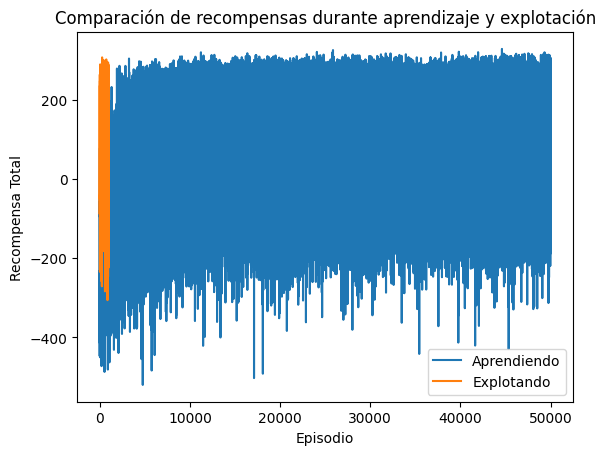

In [76]:
plt.plot(recompensa_episodios_aprendiendo, label='Aprendiendo')
plt.plot(recompensa_episodios_explotando, label='Explotando')
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')
plt.title('Comparación de recompensas durante aprendizaje y explotación')
plt.legend()
plt.show()

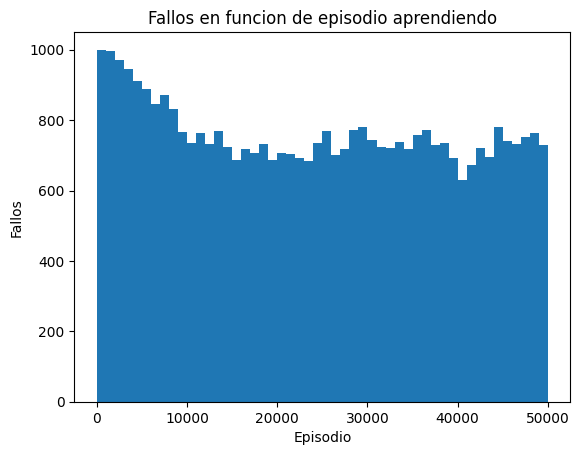

In [77]:
fallos = [1 if recompensa < 200 else 0 for recompensa in recompensa_episodios_aprendiendo]

bins = 50  # Número de intervalos (ajustable)
plt.hist(np.arange(len(fallos)), bins=bins, weights=fallos)
plt.xlabel('Episodio')
plt.ylabel('Fallos')
plt.title('Fallos en funcion de episodio aprendiendo')
plt.show()

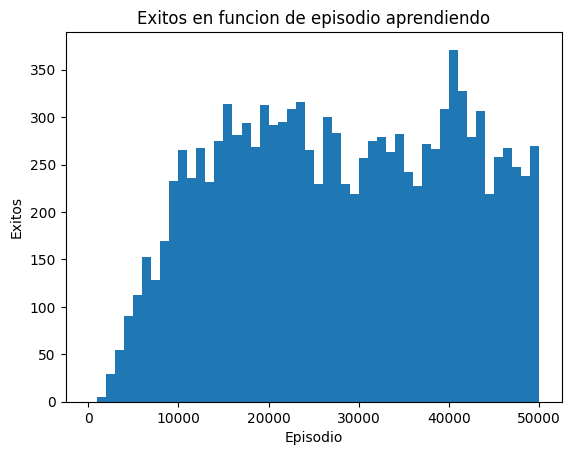

In [78]:
exitos = [1 if recompensa >= 200 else 0 for recompensa in recompensa_episodios_aprendiendo]

bins = 50  # Número de intervalos (ajustable)
plt.hist(np.arange(len(exitos)), bins=bins, weights=exitos)
plt.xlabel('Episodio')
plt.ylabel('Exitos')
plt.title('Exitos en funcion de episodio aprendiendo')
plt.show()

## Evolución de la recompensa promedio

- **Tendencia:**

	Durante la fase de aprendizaje, la recompensa promedio muestra una mejora progresiva a medida que avanzan los episodios, indicando que el agente está aprendiendo gradualmente. Al principio, se observan recompensas negativas, lo que sugiere que el agente comete más errores. Sin embargo, con el tiempo, el agente se adapta y su rendimiento mejora de manera constante, acercándose a un comportamiento estable y con recompensas cercanas o superiores a 0.

- **Estabilidad:**

	En la fase de explotación, aunque al inicio se presentan picos y caídas bruscas en la recompensa promedio, después de un número de episodios (~600), esta se estabiliza alrededor de un valor constante (~70). Esto refleja que el agente ha alcanzado un punto de toma de decisiones óptimas con menor variación. Los saltos iniciales pueden atribuirse a la naturaleza del epsilon (con un mínimo de 0.01), que introduce cierta aleatoriedad en las decisiones. Esto afecta más al cálculo del promedio de la recompensa en los primeros episodios, ya que hay menos muestras, lo que hace que las variaciones individuales tengan un mayor impacto.

- **Exploración vs Explotación:**

	La fase de exploración permite al agente mejorar su recompensa promedio gradualmente a medida que experimenta y ajusta su comportamiento. En contraste, la fase de explotación refleja una recompensa más estable, ya que el agente aplica las estrategias aprendidas con menor variabilidad. Esto subraya la importancia de la exploración inicial, donde el agente tiene la oportunidad de descubrir mejores estrategias, lo que luego se traduce en una explotación más eficiente y consistente.

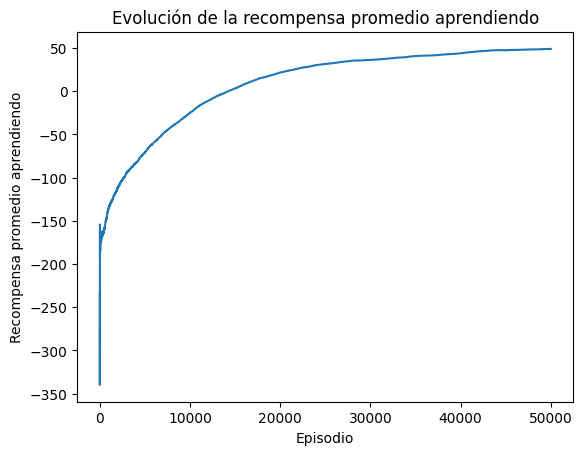

In [79]:
recompensas_promedio_aprendiendo = [np.mean(recompensa_episodios_aprendiendo[:i+1]) for i in range(num_episodios_aprendiendo)]
plt.plot(recompensas_promedio_aprendiendo, label='Aprendiendo')
plt.title("Evolución de la recompensa promedio aprendiendo")
plt.xlabel("Episodio")
plt.ylabel("Recompensa promedio aprendiendo")
plt.show()

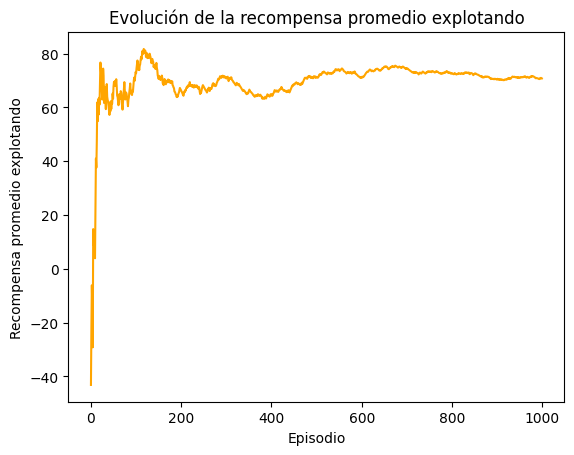

In [80]:
recompensas_promedio_explotando = [np.mean(recompensa_episodios_explotando[:i+1]) for i in range(num_episodios_explotando)]
plt.plot(recompensas_promedio_explotando, color='orange')
plt.title("Evolución de la recompensa promedio explotando")
plt.xlabel("Episodio")
plt.ylabel("Recompensa promedio explotando")
plt.show()

## Evolución de la tasa de éxito

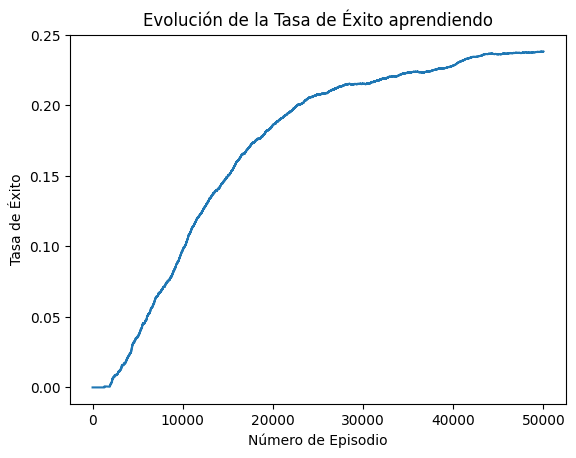

In [81]:
exitos = [1 if recompensa >= 200 else 0 for recompensa in recompensa_episodios_aprendiendo]

# Calcular la tasa de éxito acumulada
tasa_exito = np.cumsum(exitos) / (np.arange(num_episodios_aprendiendo) + 1)

plt.plot(range(num_episodios_aprendiendo), tasa_exito)
plt.xlabel('Número de Episodio')
plt.ylabel('Tasa de Éxito')
plt.title('Evolución de la Tasa de Éxito aprendiendo')
plt.show()


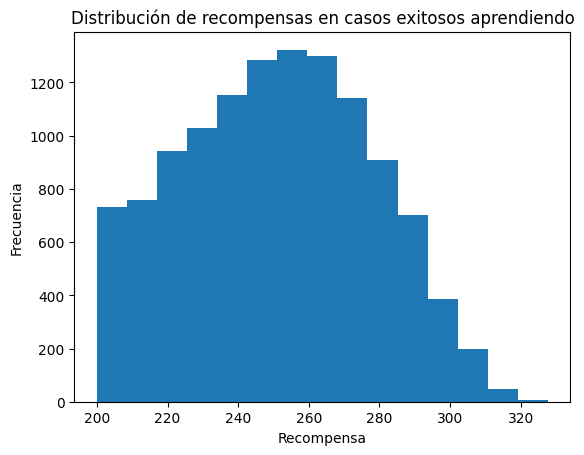

In [82]:
exitos = [recompensa for recompensa in recompensa_episodios_aprendiendo if recompensa >= 200]
plt.hist(exitos, bins=15)
plt.title("Distribución de recompensas en casos exitosos aprendiendo")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.show()

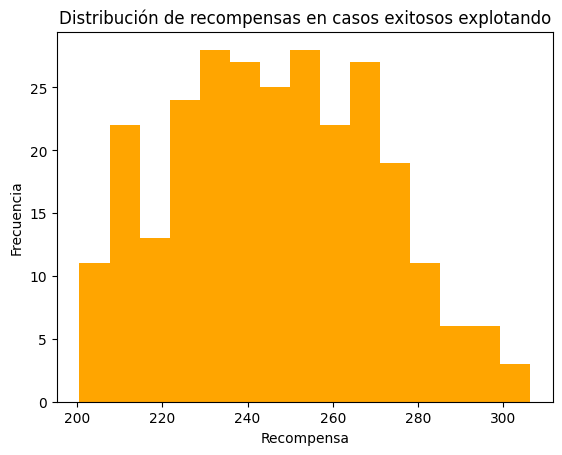

In [83]:
exitos = [recompensa for recompensa in recompensa_episodios_explotando if recompensa >= 200]
plt.hist(exitos, bins=15, color='orange')
plt.title("Distribución de recompensas en casos exitosos explotando")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.show()

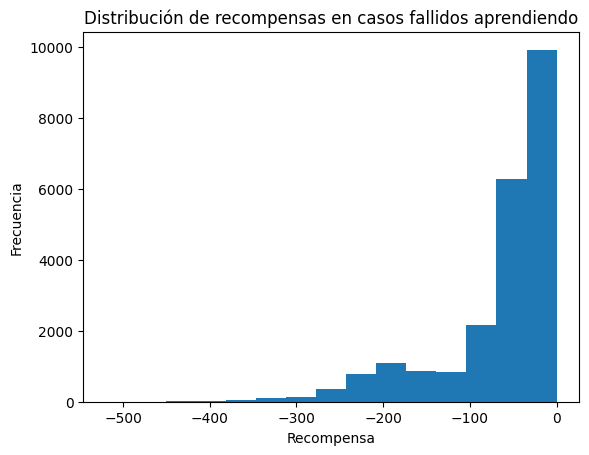

In [84]:
# Distribución de recompensas en casos fallidos: Representar las recompensas en episodios donde el agente falló.

fallos = [recompensa for recompensa in recompensa_episodios_aprendiendo if recompensa < 0]
plt.hist(fallos, bins=15)
plt.title("Distribución de recompensas en casos fallidos aprendiendo")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.show()

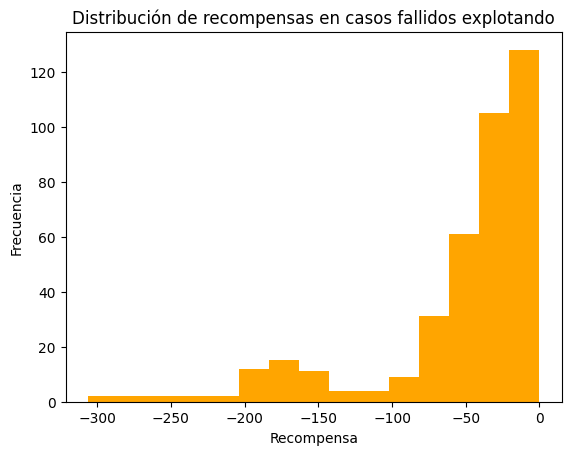

In [85]:
fallos = [recompensa for recompensa in recompensa_episodios_explotando if recompensa < 0]
plt.hist(fallos, bins=15, color='orange')
plt.title("Distribución de recompensas en casos fallidos explotando")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.show()

### Analisis de los casos de fracaso
**Fallo en la moderación del propulsor cerca del suelo**: Un comportamiento recurrente es que el agente, al acercarse al suelo, deja de utilizar el propulsor hacia arriba o reduce significativamente su uso, permitiendo que la nave descienda rápidamente y, en consecuencia, se estrelle. Esto sugiere que el agente no ha aprendido a manejar de manera adecuada el encendido y apagado del propulsor en esta etapa crítica del aterrizaje. En la dinámica del juego, mantener el propulsor encendido continuamente haría que la nave suba, mientras que apagarlo del todo haría que caiga. El equilibrio entre ambos estados es fundamental para un aterrizaje suave. La incapacidad del agente para realizar este ajuste fino indica que el proceso de aprendizaje está luchando para capturar la sutil moderación de la fuerza de propulsión necesaria en esta situación.

**Accionamiento de propulsores tras el aterrizaje**: En algunos casos, el agente aterriza, pero sigue activando algún propulsor, lo cual provoca movimientos innecesarios y a veces perjudiciales después de haber alcanzado la superficie. Este comportamiento sugiere que el agente no está comprendiendo completamente que ya ha logrado el objetivo de aterrizar y, por tanto, debería mantener la nave quieta. Este problema podría derivar de una falta de señalización clara en el modelo de que ha alcanzado una posición estable en el suelo, o una dificultad en la asignación de recompensas que le indiquen que, tras el aterrizaje, debe cesar sus esfuerzos de corrección de posición.

**Aterrizaje fuera del área designada sin intentar corregir**: Otro problema detectado es que el agente, al aterrizar fuera del área segura designada, a menudo deja de usar los propulsores para intentar reposicionarse en la zona correcta. En estas situaciones, el agente parece considerar que ha cumplido su objetivo simplemente por haber aterrizado, incluso si se encuentra en una posición incorrecta. Esto puede deberse a que, al encontrar un estado de equilibrio en el suelo, el agente asume que no hay necesidad de seguir moviéndose. Sin embargo, para un desempeño adecuado, debería ser capaz de distinguir entre un aterrizaje exitoso en la zona objetivo y uno fuera de ella, tomando las acciones necesarias para corregir su posición si es necesario.

**Selección incorrecta de propulsores al estar en el suelo**: Cuando el agente se encuentra en el suelo, especialmente en una rampa o en una posición inclinada, a veces utiliza los propulsores de manera inapropiada, impulsándose en la dirección equivocada. Este comportamiento parece ser el resultado de que el agente ha aprendido a estabilizar su ángulo mientras está en el aire, y aplica la misma estrategia en el suelo, aunque la dinámica es diferente. En el aire, el control del ángulo es esencial para mantener la estabilidad de la nave, pero en el suelo, el mismo comportamiento puede resultar en movimientos en dirección contraria a la necesaria para reposicionarse. Esto es particularmente evidente cuando la nave aterriza fuera del área segura, donde debería intentar moverse hacia la zona de aterrizaje, pero elige el propulsor equivocado y termina alejándose más.

### Análisis de algunos 'cortes' de la matriz Q 

En este apartado, se analizan las decisiones que toma el agente entrenado bajo condiciones específicas del estado de la nave. El enfoque principal de este análisis es identificar las acciones recomendadas por la tabla Q del agente cuando la nave se encuentra en situaciones críticas.

##### Cayendo rápido y sin rotación
La primera condición analizada es cuando la nave está cayendo rápidamente sin rotación significativa. Para detectar esta situación, se define un rango de bins para la velocidad vertical (y_vel) que representa una caída rápida, mientras que tanto el ángulo de la nave (theta) como su velocidad angular (theta_vel) deben estar dentro de un rango cercano a cero, indicando que la nave está alineada verticalmente sin rotar. Los resultados obtenidos indican las veces que el agente ha seleccionado cada una de las acciones posibles bajo esta condición.

In [90]:
# Condición: cayendo rápido y sin rotación
bins_cayendo_rapido = list(range(0, 7))  # Velocidad vertical rapida (negativa)
bins_sin_rotacion = list(range(5, 10))  # Ángulo y velocidad angular cerca de 0
contador_acciones = [0, 0, 0, 0]

for estado, valores_q in agente.q_table.items():
    _, _, x_vel_bin, y_vel_bin, theta_bin, theta_vel_bin, pie_izq, pie_der = estado
    if (y_vel_bin in bins_cayendo_rapido and theta_bin in bins_sin_rotacion and theta_vel_bin in bins_sin_rotacion):
        accion_recomendada = np.argmax(valores_q)
        contador_acciones[accion_recomendada] += 1

print('Condición: cayendo rápido y sin rotación')
print(f'Acción 0 (no hacer nada): {contador_acciones[0]} veces')
print(f'Acción 1 (activar propulsor izquierdo): {contador_acciones[1]} veces')
print(f'Acción 2 (activar motor principal): {contador_acciones[2]} veces')
print(f'Acción 3 (activar propulsor derecho): {contador_acciones[3]} veces')

Condición: cayendo rápido y sin rotación
Acción 0 (no hacer nada): 2183 veces
Acción 1 (activar propulsor izquierdo): 1713 veces
Acción 2 (activar motor principal): 2451 veces
Acción 3 (activar propulsor derecho): 1077 veces


Como se puede observar, la acción que toma nuestro agente con mayor frecuencia es activar el motor principal, la cual puede no ser una mala opción en algunas ocasiones si el agente entiende que es mejor reducir la velocidad para reducir el impacto. Seguido de esta está que no haga nada, si el agente evalúa que su velocidad vertical no es demasiado alta o tiene una posición estable, puede optar por no accionar ningún propulsor. Finalmente aparecen las acciones de activar los propulsores laterales, los cuales no son una opción deseada ya que pueden descarrilar al agente de su objetivo final. A pesar de que el orden de las acciones es el esperado, la proporción no es tan alejada, lo cual podría ser un punto débil de nuestro agente.

##### Rotación sin control hacia la izquierda
La segunda condición analizada es cuando la nave está rotando de forma incontrolada hacia la izquierda. Para capturar este estado, se utilizan los bins correspondientes a un ángulo y una velocidad angular negativos, lo que indica una inclinación y rotación hacia la izquierda. Se evalúan las decisiones del agente en estos casos para determinar qué acciones prefiere tomar para corregir o controlar la situación.

In [89]:
bins_rotacion_izquierda = list(range(0, 5))  # Theta_vel negativa (sentido antihorario)
bins_inclinacion_izquierda = list(range(0, 5))  # Theta negativo (inclinación hacia la izquierda)
contador_acciones = [0, 0, 0, 0]
for estado, valores_q in agente.q_table.items():
    _, _, _, _, theta_bin, theta_vel_bin, pie_izq, pie_der = estado
    if (theta_vel_bin in bins_rotacion_izquierda and theta_bin in bins_inclinacion_izquierda):
        accion_recomendada = np.argmax(valores_q)
        contador_acciones[accion_recomendada] += 1

print('Condición: rotación sin control hacia la izquierda')
print(f'Acción 0 (no hacer nada): {contador_acciones[0]} veces')
print(f'Acción 1 (activar propulsor izquierdo): {contador_acciones[1]} veces')
print(f'Acción 2 (activar motor principal): {contador_acciones[2]} veces')
print(f'Acción 3 (activar propulsor derecho): {contador_acciones[3]} veces')

Condición: rotación sin control hacia la izquierda
Acción 0 (no hacer nada): 128 veces
Acción 1 (activar propulsor izquierdo): 178 veces
Acción 2 (activar motor principal): 98 veces
Acción 3 (activar propulsor derecho): 57 veces


En este caso, también ocurrió lo que se esperaba con más frecuencia. Cuando el agente está girando sin control en sentido antihorario, lo que nuestro agente suele hacer es activar el propulsor izquierdo para poder enderezar al agente. De todas formas no hacer nada es la opción que le sigue de forma muy cercana como alternativa.

##### Rotación sin control hacia la derecha
Finalmente, se considera el caso opuesto, donde la nave está rotando sin control hacia la derecha. En este escenario, se seleccionan los bins correspondientes a ángulos y velocidades angulares positivas. Al igual que en el caso anterior, se examinan las acciones seleccionadas por el agente para estabilizar la nave o corregir la rotación.



In [88]:
# Condición: rotación sin control hacia la derecha
bins_rotacion_derecha = list(range(10, 15))  # Theta_vel positiva (sentido horario)
bins_inclinacion_derecha = list(range(10, 15))  # Theta positiva (inclinación hacia la derecha)
contador_acciones = [0, 0, 0, 0]
for estado, valores_q in agente.q_table.items():
    _, _, _, _, theta_bin, theta_vel_bin, pie_izq, pie_der = estado
    if (theta_vel_bin in bins_rotacion_derecha and theta_bin in bins_inclinacion_derecha):
        accion_recomendada = np.argmax(valores_q)
        contador_acciones[accion_recomendada] += 1
print('Condición: rotación sin control hacia la derecha')
print(f'Acción 0 (no hacer nada): {contador_acciones[0]} veces')
print(f'Acción 1 (activar propulsor izquierdo): {contador_acciones[1]} veces')
print(f'Acción 2 (activar motor principal): {contador_acciones[2]} veces')
print(f'Acción 3 (activar propulsor derecho): {contador_acciones[3]} veces')


Condición: rotación sin control hacia la derecha
Acción 0 (no hacer nada): 165 veces
Acción 1 (activar propulsor izquierdo): 232 veces
Acción 2 (activar motor principal): 125 veces
Acción 3 (activar propulsor derecho): 91 veces


En el caso de la rotación sin control hacia la derecha, los resultados muestran algo interesante. Aunque el agente debería estar activando el propulsor derecho con más frecuencia para corregir la rotación hacia la derecha, lo que más hace es activar el propulsor izquierdo, lo cual no es lo ideal. Esto sugiere que el agente no está aprendiendo correctamente cómo estabilizarse en esta situación. Además, aunque la opción de no hacer nada también aparece bastante, lo que sería razonable en algunos casos, las acciones de activar el motor principal y el propulsor derecho (que sí deberían ayudar a contrarrestar la rotación) se eligen mucho menos de lo que deberían, lo cual es un comportamiento que habría que mejorar.

### Posibles mejoras para el algoritmo:
##### Implementación de retrocesos: 
Una posible mejora sería implementar la técnica de retrocesos que se menciona en el material teórico. Esta técnica puede ser muy beneficiosa para optimizar los tiempos de aprendizaje en Q-learning. Los retrocesos permitirían que el agente aprenda de manera más eficiente, especialmente en situaciones donde la exploración inicial del espacio de estados no es lo suficientemente completa. Al permitir que el agente realice revisiones o correcciones sobre decisiones previas, podría mejorar la convergencia y hacer que el aprendizaje sea más rápido.

##### Uso de un alfa variable:
 Actualmente, el algoritmo emplea una fórmula de Q-learning no determinista con un valor de alfa fijo. Sin embargo, este valor de alfa fijo podría no ser el más eficiente a lo largo del proceso de aprendizaje. Una mejora posible sería implementar un alfa variable que se ajuste en función de la cantidad de veces que un estado ha sido visitado. Esto permitiría que los estados más explorados (y que han tenido suficientes actualizaciones) reciban un peso menor en las actualizaciones de Q(s, a), mientras que los estados menos visitados puedan ser actualizados más rápidamente. De este modo, el agente variaría menos el valor de Q(s, a) para aquellas entradas que fueron evaluadas muchas veces. 